In [1]:
using Plots,LinearAlgebra,Interpolations, Random, Distributions, Roots, NLopt, ForwardDiff, LaTeXStrings, DifferentialEquations, SimpleDiffEq
gr();#Load in packages

In [2]:
function diff!(du,u,p,t) #System of ODEs obtained by applying method of lines with standard central difference approximation
dx,N,Drr,Dgg,krr,kgg=p

for i in 2:N-1
du[1,i]=Drr*(u[1,i-1]-2*u[1,i]+u[1,i+1])/dx^2-krr*u[1,i]+2*kgg*u[2,i]*(1.0-u[1,i]-u[2,i]) 
du[2,i]=Dgg*(u[2,i-1]-2*u[2,i]+u[2,i+1])/dx^2+krr*u[1,i]-kgg*u[2,i]*(1.0-u[1,i]-u[2,i])
end
    
i=1
du[1,i]=Drr*(u[1,i+1]-u[1,i])/dx^2-krr*u[1,i]+2*kgg*u[2,i]*(1.0-u[1,i]-u[2,i]) 
du[2,i]=Dgg*(u[2,i+1]-u[2,i])/dx^2+krr*u[1,i]-kgg*u[2,i]*(1.0-u[1,i]-u[2,i])
    
i=N
du[1,i]=Drr*(u[1,i-1]-u[1,i])/dx^2-krr*u[1,i]+2*kgg*u[2,i]*(1.0-u[1,i]-u[2,i]) 
du[2,i]=Dgg*(u[2,i-1]-u[2,i])/dx^2+krr*u[1,i]-kgg*u[2,i]*(1.0-u[1,i]-u[2,i])        
end

diff! (generic function with 1 method)

In [3]:
function pdesolver(L,dx,N,T,ic,Dr,Dg,kr,kg) #Solve the system of ODEs
Drr=exp(Dr); Dgg=exp(Dg); krr=exp(kr); kgg = exp(kg);    
p=(dx,N,Drr,Dgg,krr,kgg)
tspan=(0.0,maximum(T));
prob=ODEProblem(diff!,ic,tspan,p);
alg=Heun()
sol=solve(prob,alg,saveat=T);
return sol
end

pdesolver (generic function with 1 method)

In [4]:
Dr=log(700.0); Dg=log(300.0); kr=log(0.027); kg=log(0.073); #Parameter estimates
L=1242.0; dx=5.0; #Domain and discretisation
N=Int(round(L/dx))+1;
T=[0, 16, 32, 48]; #Time at which we wish to obtain the solution
numsol=zeros(2,N,length(T));
ic=zeros(2,N);
xx=zeros(N);
data=zeros(2,24,length(T));
count=zeros(2,24,length(T));
xlocdata =[0, 54, 108, 162, 216, 270, 324, 378, 432, 486, 540, 594, 648, 702, 756, 810, 864, 918, 972, 1026, 1080, 1134, 1188, 1242];
count[1,:,1] = [23, 19, 15, 27, 19, 18, 13, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 19, 23, 30, 26, 22, 20]; 
count[2,:,1] = [24, 14, 21, 13, 13, 18, 19, 6, 1, 0, 0, 0, 0, 0, 0, 0, 2, 14, 22, 14, 12, 13, 13, 15];
count[1,:,2] = [35, 37, 43, 25, 41, 31, 20, 21, 14, 10, 3, 1, 1, 2, 1, 10, 26, 32, 26, 27, 37, 34, 38, 38];
count[2,:,2] = [22, 14, 15, 12, 16, 11, 12, 12, 11, 6, 1, 0, 0, 1, 1, 4, 6, 12, 18, 19, 13, 12, 15, 10];
count[1,:,3] = [50, 42, 33, 40, 37, 23, 21, 19, 21, 19, 8, 6, 3, 6, 8, 15, 29, 29, 35, 38, 42, 44, 42, 53];
count[2,:,3] = [20, 14, 22, 13, 22, 16, 11, 15, 13, 11, 3, 2, 2, 2, 4, 10, 13, 9, 12, 13, 12, 14, 16, 17];
count[1,:,4] = [55, 53, 51, 52, 33, 39, 42, 41, 37, 41, 23, 24, 19, 18, 23, 28, 36, 32, 42, 45, 48, 48, 52, 50];
count[2,:,4] = [20, 15, 15, 14, 16, 17, 11, 10, 13, 7, 11, 7, 8, 4, 6, 13, 16, 14, 11, 12, 17, 18, 17, 25]
count=round.(Int,count) #Count data
maxcount=377; #Maximum number of cells per column
data=count/maxcount


interpr = linear_interpolation(xlocdata,data[1,:,1]);
interpg = linear_interpolation(xlocdata,data[2,:,1]); #Interpolate initial density 

for i in 1:N
xx[i]= (i-1)*dx
ic[1,i] = interpr(xx[i])
ic[2,i] = interpg(xx[i])    
end

In [5]:
function loglhood(count,ic,a) #loglikelihood function using multinomial noise model
numsol=pdesolver(L,dx,N,T,ic,a[1],a[2],a[3],a[4])
r2 = linear_interpolation(0:dx:L,numsol[1,:,2],extrapolation_bc=Line()); 
r3 = linear_interpolation(0:dx:L,numsol[1,:,3],extrapolation_bc=Line()); 
r4 = linear_interpolation(0:dx:L,numsol[1,:,4],extrapolation_bc=Line());
g2 = linear_interpolation(0:dx:L,numsol[2,:,2],extrapolation_bc=Line()); 
g3 = linear_interpolation(0:dx:L,numsol[2,:,3],extrapolation_bc=Line()); 
g4 = linear_interpolation(0:dx:L,numsol[2,:,4],extrapolation_bc=Line());
ℓ=0.0
for ii in 1:size(count)[2]
ℓ+=(
  +log(r2(xlocdata[ii])^count[1,ii,2]*g2(xlocdata[ii])^count[2,ii,2]*(1.0-r2(xlocdata[ii])-g2(xlocdata[ii]))^(377.0-count[1,ii,2]-count[2,ii,2]))
  +log(r3(xlocdata[ii])^count[1,ii,3]*g3(xlocdata[ii])^count[2,ii,3]*(1.0-r3(xlocdata[ii])-g3(xlocdata[ii]))^(377.0-count[1,ii,3]-count[2,ii,3]))
  +log(r4(xlocdata[ii])^count[1,ii,4]*g4(xlocdata[ii])^count[2,ii,3]*(1.0-r4(xlocdata[ii])-g4(xlocdata[ii]))^(377.0-count[1,ii,4]-count[2,ii,4]))
   )
end
return ℓ
end;

In [6]:
function funmle(a) #Evaluate the loglikelihood function
return loglhood(count,ic,a)
end;

In [7]:
function Optimise(fun,θ₀,lb,ub) #Optimisation routine using Nelder Mead
tomax=(θ,∂θ)->fun(θ)
opt=Opt(:LN_NELDERMEAD,length(θ₀))
opt.max_objective=tomax
opt.lower_bounds=lb      
opt.upper_bounds=ub
optmaxtime=1*60
res = optimize(opt,θ₀)
return res[[2,1]]
end;

In [9]:
@time numsolmle=pdesolver(L,dx,N,T,ic,Dr,Dg,kr,kg); #Solve the PDE model and check the compute time

  0.007656 seconds (173 allocations: 69.312 KiB)


In [10]:
θG=[Dr,Dg,kr,kg] #Parameter estimate
lb=[log(50),log(50),log(0.001),log(0.001)] #Bounds
ub=[log(2000),log(2000),log(0.2),log(0.2)] #Bounds
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub) #Optimisation
exp.(xopt)

  4.034366 seconds (2.00 M allocations: 125.989 MiB, 16.24% compilation time)


4-element Vector{Float64}:
 696.9937272867282
 377.2503242809863
   0.028228003418610762
   0.0708414148835917

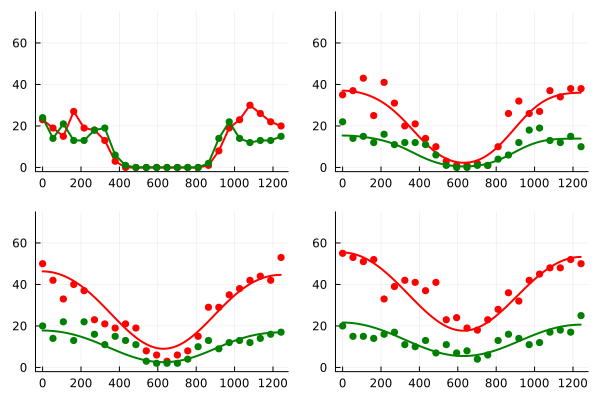

In [11]:
Drmle=xopt[1]; Dgmle=xopt[2]; krmle=xopt[3]; kgmle=xopt[4]; fmle=fopt #Evaluate MLE solution and plot it on the data as a visual check
numsolmle=pdesolver(L,dx,N,T,ic,xopt[1],xopt[2],xopt[3],xopt[4]); 
p1=scatter(xlocdata,count[1,:,1],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p1=plot!(xx,maxcount*numsolmle[1,:,1],lw=2,color=:red)
p1=scatter!(xlocdata,count[2,:,1],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p1=plot!(xx,maxcount*numsolmle[2,:,1],lw=2,color=:green)

p2=scatter(xlocdata,count[1,:,2],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p2=plot!(xx,maxcount*numsolmle[1,:,2],lw=2,color=:red)
p2=scatter!(xlocdata,count[2,:,2],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p2=plot!(xx,maxcount*numsolmle[2,:,2],lw=2,color=:green)

p3=scatter(xlocdata,count[1,:,3],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p3=plot!(xx,maxcount*numsolmle[1,:,3],lw=2,color=:red)
p3=scatter!(xlocdata,count[2,:,3],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p3=plot!(xx,maxcount*numsolmle[2,:,3],lw=2,color=:green)

p4=scatter(xlocdata,count[1,:,4],markercolor=:red,markerstrokecolor=:red,markersize=4,legend=false,ylims=(-2,75))
p4=plot!(xx,maxcount*numsolmle[1,:,4],lw=2,color=:red)
p4=scatter!(xlocdata,count[2,:,4],markercolor=:green,markerstrokecolor=:green,markersize=4,legend=false,ylims=(-2,75))
p4=plot!(xx,maxcount*numsolmle[2,:,4],lw=2,color=:green)

p5=plot(p1,p2,p3,p4,layout=(2,2))
display(p5)

In [12]:
ff(θ1,θ2,θ3,θ4) = funmle([θ1,θ2,θ3,θ4]) #Evaluate the Observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> ff(z[1],z[2],z[3],z[4]),xopt)

4×4 Matrix{Float64}:
 129.053     45.6484    -18.1278     -0.176667
  45.6484    22.9436     -9.81829     4.27127
 -18.1278    -9.81829   663.407    -105.916
  -0.176667   4.27127  -105.916     758.23

In [13]:
rank(H) #Compute the rank of the observed Fisher Information at the MLE

4

In [14]:
(evals,evecs)=eigen(H) #Compute the eigenvectors/eigenvalues of the observed Fisher Information at the MLE

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
   5.978101331307457
 145.17086345527864
 595.3735144256585
 827.1116058125533
vectors:
4×4 Matrix{Float64}:
  0.347278    -0.937029     0.0340417   0.0147156
 -0.937742    -0.346882     0.0130143   0.0119395
 -0.00364048  -0.0403344   -0.837609   -0.544768
  0.00489346  -0.00482168  -0.545054    0.838373

In [15]:
Q=30 #Set up grids to evaluate the univariate profile likelihoods
Drmin=log(100);  Drmax=log(1500);  DDr=LinRange(Drmin,Drmax,Q);
Dgmin=log(100);  Dgmax=log(1500);  DDg=LinRange(Dgmin,Dgmax,Q)
krmin=log(0.020); krmax=log(0.04);   kkr=LinRange(krmin,krmax,Q);
kgmin=log(0.06); kgmax=log(0.08);  kkg=LinRange(kgmin,kgmax,Q);

In [16]:
#Univariate Profiles
df=1
llstar=-quantile(Chisq(df),0.95)/2;

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


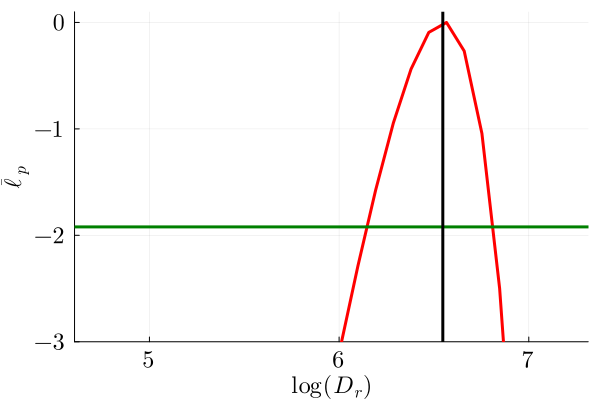

In [17]:
#Function to define univariate profile for Dr 
function Drr(Dr)
a=zeros(3)    
function funDr(a)
return loglhood(count,ic,[Dr,a[1],a[2],a[3]])
end
θG=[Dgmle,krmle,kgmle]
lb=[Dgmin,krmin,kgmin]
ub=[Dgmax,krmax,kgmax]
(xopt,fopt)=Optimise(funDr,θG,lb,ub)
llb=fopt
return llb,xopt
end 

lp=zeros(Q)
for i in 1:Q
println(i)
lp[i] = Drr(DDr[i])[1]
end
q1=plot(DDr,lp.-maximum(lp),ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q1=hline!([llstar],legend=false,lw=3,lc=:green)
q1=vline!([Drmle],lc=:black,legend=false,xlabel=L"\log (D_r)",ylabel=L"\bar{\ell}_p",lw=3)
q1=plot!(xlims=(minimum(DDr),maximum(DDr)),xticks=([5,  6,  7],[L"5",L"6",L"7"]))
q1=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


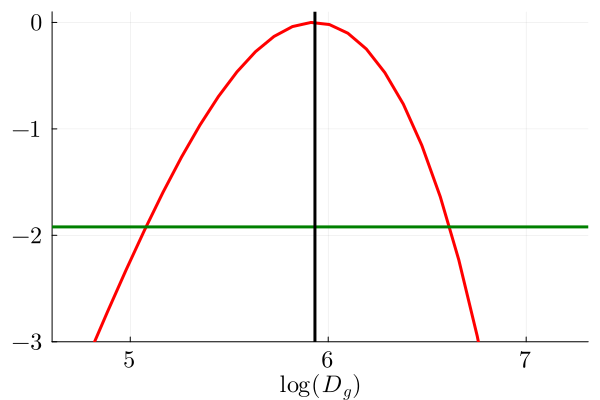

In [18]:
#Function to define univariate profile for Dg 
function Dgg(Dg)
a=zeros(3)    
function funDg(a)
return loglhood(count,ic,[a[1],Dg,a[2],a[3]])
end
θG=[Drmle,krmle,kgmle]
lb=[Drmin,krmin,kgmin]
ub=[Drmax,krmax,kgmax]
(xopt,fopt)=Optimise(funDg,θG,lb,ub)
llb=fopt
return llb,xopt
end 

lp=zeros(Q)
for i in 1:Q
    println(i)
lp[i] = Dgg(DDg[i])[1]
end
q2=plot(DDg,lp.-maximum(lp),ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q2=hline!([llstar],legend=false,lw=3,lc=:green)
q2=vline!([Dgmle],lc=:black,legend=false,xlabel=L"\log (D_g)",lw=3)
q2=plot!(xlims=(minimum(DDg),maximum(DDg)),xticks=([5,  6,  7],[L"5",L"6",L"7"]))
q2=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q2=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


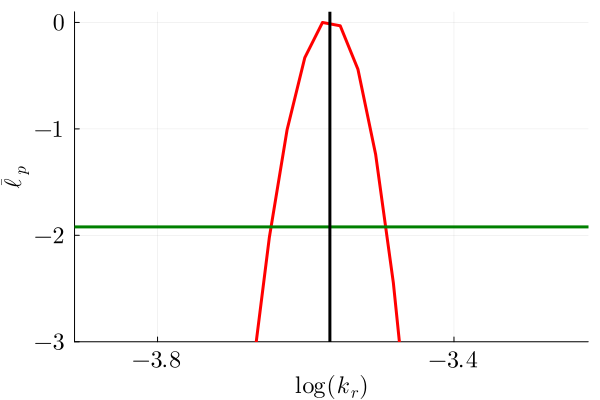

In [22]:
#Function to define univariate profile for kr 
function krr(kr)
a=zeros(3)    
function funkr(a)
return loglhood(count,ic,[a[1],a[2],kr,a[3]])
end
θG=[Drmle,Dgmle,kgmle]
lb=[Drmin,Dgmin,kgmin]
ub=[Drmax,Dgmax,kgmax]
(xopt,fopt)=Optimise(funkr,θG,lb,ub)
llb=fopt
return llb,xopt
end 

lp=zeros(Q)
for i in 1:Q
println(i)
lp[i] = krr(kkr[i])[1]
end
q3=plot(kkr,lp.-maximum(lp),ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q3=hline!([llstar],legend=false,lw=3,lc=:green)
q3=vline!([krmle],lc=:black,legend=false,xlabel=L"\log(k_r)",ylabel=L"\bar{\ell}_p",lw=3)
q3=plot!(xlims=(minimum(kkr),maximum(kkr)),xticks=([-3.8, -3.4],[L"-3.8",L"-3.4"]))
q3=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q3=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


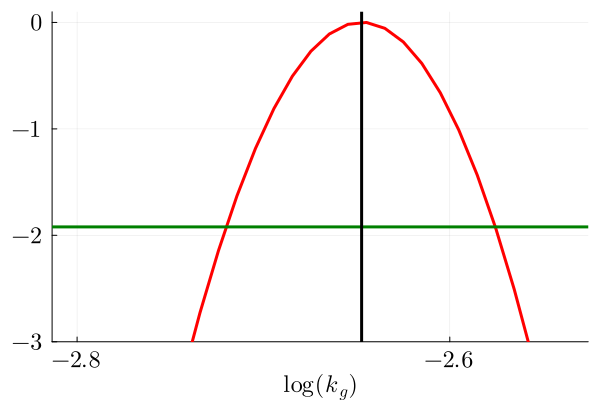

In [23]:
#Function to define univariate profile for kg 
function kgg(kg)
a=zeros(3)    
function funkg(a)
return loglhood(count,ic,[a[1],a[2],a[3],kg])
end
θG=[Drmle,Dgmle,krmle]
lb=[Drmin,Dgmin,krmin]
ub=[Drmax,Dgmax,krmax]
(xopt,fopt)=Optimise(funkg,θG,lb,ub)
llb=fopt
return llb,xopt
end 

lp=zeros(Q)
for i in 1:Q
println(i)
lp[i] = kgg(kkg[i])[1]
end
q4=plot(kkg,lp.-maximum(lp),ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q4=hline!([llstar],legend=false,lw=3,lc=:green)
q4=vline!([kgmle],lc=:black,legend=false,xlabel=L"\log (k_g)",lw=3)
q4=plot!(xlims=(minimum(kkg),maximum(kkg)),xticks=([-2.8, -2.6],[L"-2.8",L"-2.6"]))
q4=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q4=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

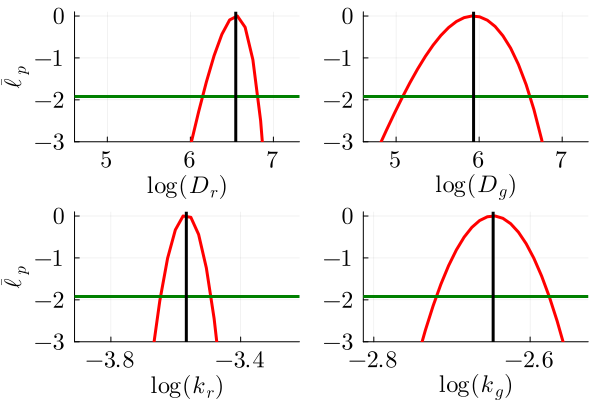

In [24]:
q5=plot(q1,q2,q3,q4,layout=(2,2))
savefig(q5,"Figure10.pdf")
display(q5)

In [25]:
QQ=20 #Setting up grids for bivariate profile likelihoods
Drmin=log(300); Drmax=log(1500);  DDr=LinRange(Drmin,Drmax,QQ);
Dgmin=log(100); Dgmax=log(1500);  DDg=LinRange(Dgmin,Dgmax,QQ)
krmin=log(0.02); krmax=log(0.04); kkr=LinRange(krmin,krmax,QQ);
kgmin=log(0.050); kgmax=log(0.09); kkg=LinRange(kgmin,kgmax,QQ);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


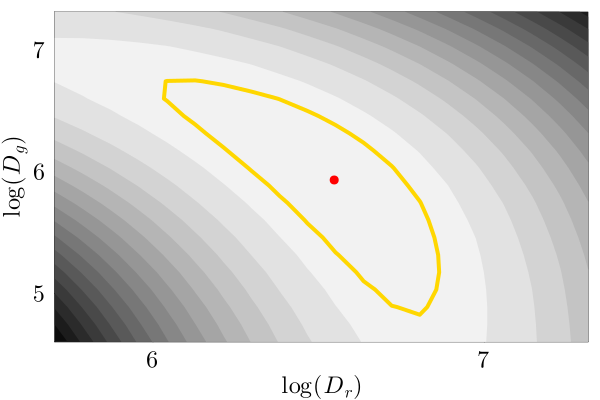

In [26]:
## Function to define bivariate profile for Dr and Dg 
df=2
llstar=-quantile(Chisq(df),0.95)/2

function DrDg(Dr,Dg)
a=zeros(2)    
function funDrDg(a)
return loglhood(count,ic,[Dr,Dg,a[1],a[2]])
end
θG=[krmle,kgmle]
lb=[krmin,kgmin]
ub=[krmax,kgmax]
(xopt,fopt)=Optimise(funDrDg,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp=zeros(QQ,QQ)
for i in 1:QQ
    println(i)
    for j in 1:QQ
    lp[i,j] = DrDg(DDr[i],DDg[j])[1]-fmle
    end
end
b1=contourf(DDr,DDg,lp',lw=0,xlabel=L"\log (D_r)",ylabel=L"\log (D_g)",c=:grays,colorbar=:false)
b1=scatter!([Drmle],[Dgmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b1=contour!(DDr,DDg,lp',levels=[llstar],lw=4,c=:gold,legend=false)
b1=plot!(xlims=(Drmin,Drmax),xticks=([6, 7],[L"6",L"7"]))
b1=plot!(ylims=(Dgmin,Dgmax),yticks=([5, 6, 7],[L"5", L"6",L"7"]))
b1=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


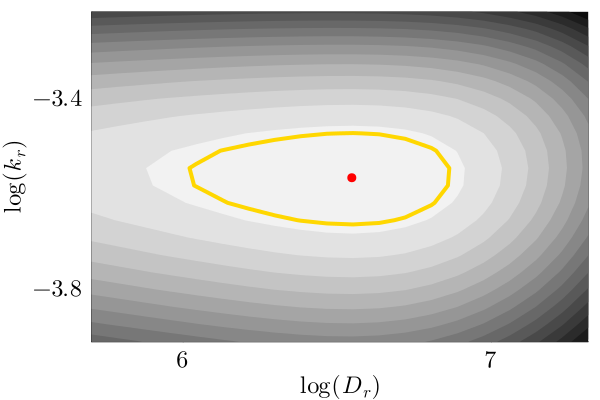

In [27]:
## Function to define bivariate profile for Dr and kr 
function Drkr(Dr,kr)
a=zeros(2)    
function funDrkr(a)
return loglhood(count,ic,[Dr,a[1],kr,a[2]])
end
θG=[Dgmle,kgmle]
lb=[Dgmin,kgmin]
ub=[Dgmax,kgmax]
(xopt,fopt)=Optimise(funDrkr,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp2=zeros(QQ,QQ)
for i in 1:QQ
println(i)
    for j in 1:QQ
    lp2[i,j] = Drkr(DDr[i],kkr[j])[1]-fmle
    end
end



b2=contourf(DDr,kkr,lp2',lw=0,xlabel=L"\log (D_r)",ylabel=L"\log (k_r)",c=:grays,colorbar=:false)
b2=scatter!([Drmle],[krmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b2=contour!(DDr,kkr,lp2',levels=[llstar],lw=4,c=:gold,legend=false)
b2=plot!(xlims=(Drmin,Drmax),xticks=([6, 7],[L"6",L"7"]))
b2=plot!(ylims=(krmin,krmax),yticks=([-3.4, -3.8],[L"-3.4",L"-3.8"]))
b2=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


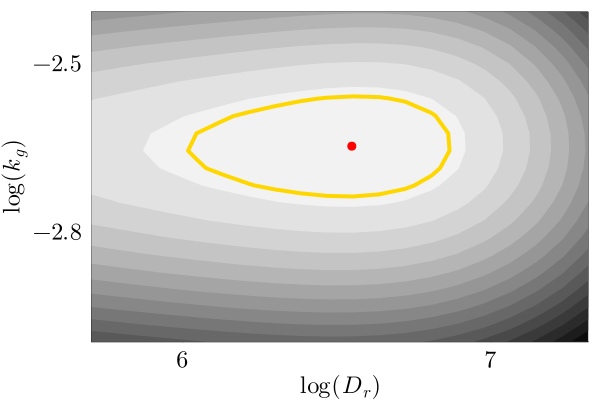

In [28]:
## Function to define bivariate profile for Dr and kg 
function Drkg(Dr,kg)
a=zeros(2)    
function funDrkg(a)
return loglhood(count,ic,[Dr,a[1],a[2],kg])
end
θG=[Dgmle,krmle]
lb=[Dgmin,krmin]
ub=[Dgmax,krmax]
(xopt,fopt)=Optimise(funDrkg,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp3=zeros(QQ,QQ)
for i in 1:QQ
println(i)
    for j in 1:QQ
    lp3[i,j] = Drkg(DDr[i],kkg[j])[1]-fmle
    end
end



b3=contourf(DDr,kkg,lp3',lw=0,xlabel=L"\log (D_r)",ylabel=L"\log (k_g)",c=:grays,colorbar=:false)
b3=scatter!([Drmle],[kgmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b3=contour!(DDr,kkg,lp3',levels=[llstar],lw=4,c=:gold,legend=false)
b3=plot!(xlims=(Drmin,Drmax),xticks=([6, 7],[L"6",L"7"]))
b3=plot!(ylims=(kgmin,kgmax),yticks=([-2.8, -2.5],[L"-2.8",L"-2.5"]))
b3=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b3)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


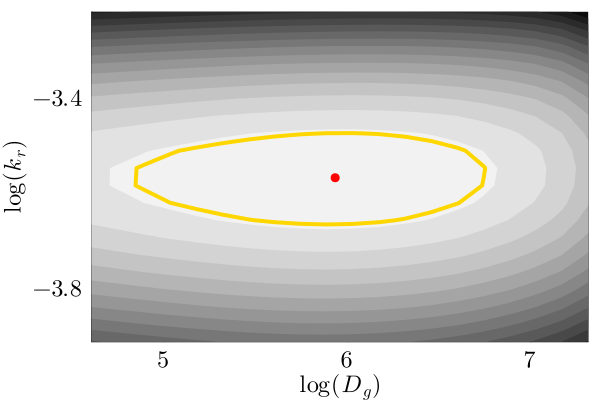

In [29]:
## Function to define bivariate profile for Dg and kr 
function Dgkr(Dg,kr)
a=zeros(2)    
function funDgkr(a)
return loglhood(count,ic,[a[1],Dg,kr,a[2]])
end
θG=[Drmle,kgmle]
lb=[Drmin,kgmin]
ub=[Drmax,kgmax]
(xopt,fopt)=Optimise(funDgkr,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp4=zeros(QQ,QQ)
for i in 1:QQ
println(i)
    for j in 1:QQ
    lp4[i,j] = Dgkr(DDg[i],kkr[j])[1]-fmle
    end
end



b4=contourf(DDg,kkr,lp4',lw=0,xlabel=L"\log (D_g)",ylabel=L"\log (k_r)",c=:grays,colorbar=:false)
b4=scatter!([Dgmle],[krmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b4=contour!(DDg,kkr,lp4',levels=[llstar],lw=4,c=:gold,legend=false)
b4=plot!(xlims=(Dgmin,Dgmax),xticks=([5, 6, 7],[L"5", L"6", L"7"]))
b4=plot!(ylims=(krmin,krmax),yticks=([-3.8, -3.4 ],[L"-3.8", L"-3.4"]))
b4=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b4)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


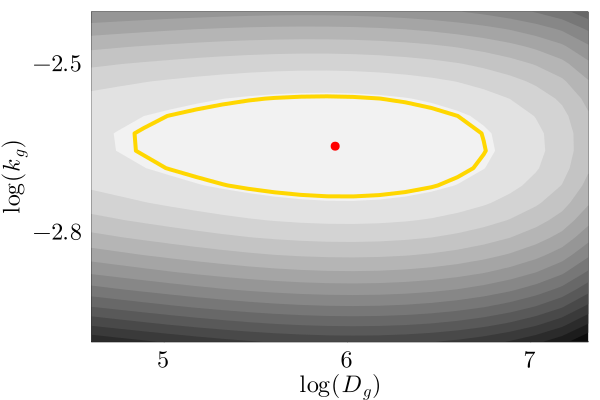

In [30]:
## Function to define bivariate profile for Dg and kg 
function Dgkg(Dg,kg)
a=zeros(2)    
function funDgkg(a)
return loglhood(count,ic,[a[1],Dg,a[2],kg])
end
θG=[Drmle,krmle]
lb=[Drmin,krmin]
ub=[Drmax,krmax]
(xopt,fopt)=Optimise(funDgkg,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp5=zeros(QQ,QQ)
for i in 1:QQ
println(i)
    for j in 1:QQ
    lp5[i,j] = Dgkg(DDg[i],kkg[j])[1]-fmle
    end
end



b5=contourf(DDg,kkg,lp5',lw=0,xlabel=L"\log (D_g)",ylabel=L" \log (k_g)",c=:grays,colorbar=:false)
b5=scatter!([Dgmle],[kgmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b5=contour!(DDg,kkg,lp5',levels=[llstar],lw=4,c=:gold,legend=false)
b5=plot!(xlims=(Dgmin,Dgmax),xticks=([5, 6, 7],[L"5", L"6", L"7"]))
b5=plot!(ylims=(kgmin,kgmax),yticks=([-2.8, -2.5],[L"-2.8",L"-2.5"]))
b5=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b5)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


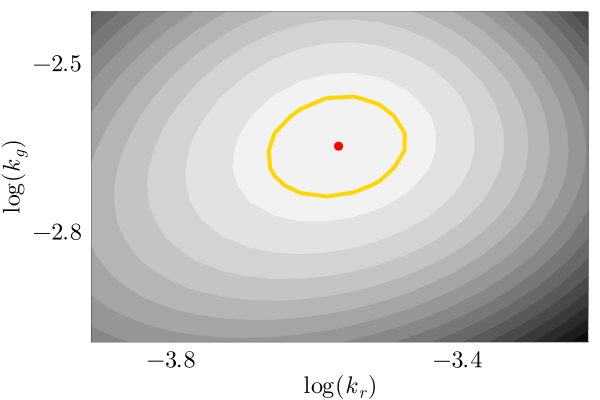

In [31]:
## Function to define bivariate profile for kr and kg 
function krkg(kr,kg)
a=zeros(2)    
function funkrkg(a)
return loglhood(count,ic,[a[1],a[2],kr,kg])
end
θG=[Drmle,Dgmle]
lb=[Drmin,Dgmin]
ub=[Drmax,Dgmax]
(xopt,fopt)=Optimise(funkrkg,θG,lb,ub)
llb=fopt
return llb,xopt
end 


lp6=zeros(QQ,QQ)
for i in 1:QQ
println(i)
    for j in 1:QQ
    lp6[i,j] = krkg(kkr[i],kkg[j])[1]-fmle
    end
end

b6=contourf(kkr,kkg,lp6',lw=0,xlabel=L"\log (k_r)",ylabel=L"\log (k_g)",c=:grays,colorbar=:false)
b6=scatter!([krmle],[kgmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b6=contour!(kkr,kkg,lp6',levels=[llstar],lw=4,c=:gold,legend=false)
b6=plot!(xlims=(krmin,krmax),xticks=([-3.8, -3.4],[L"-3.8",L"-3.4"]))
b6=plot!(ylims=(kgmin,kgmax),yticks=([-2.8, -2.5],[L"-2.8",L"-2.5"]))
b6=plot!(xguidefontsize=16,yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(b6)

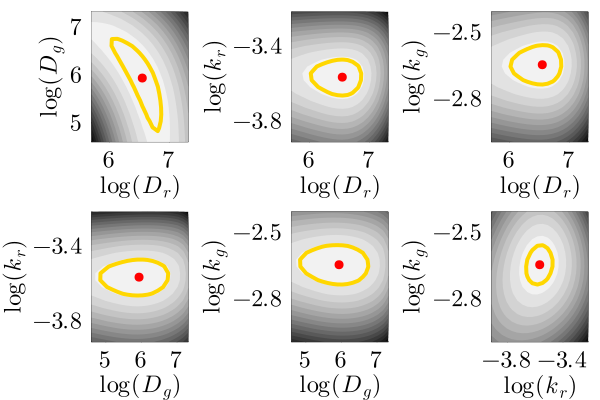

In [32]:
b7=plot(b1,b2,b3,b4,b5,b6,layout=(2,3))
savefig(b7,"Figure7.pdf")
display(b7)

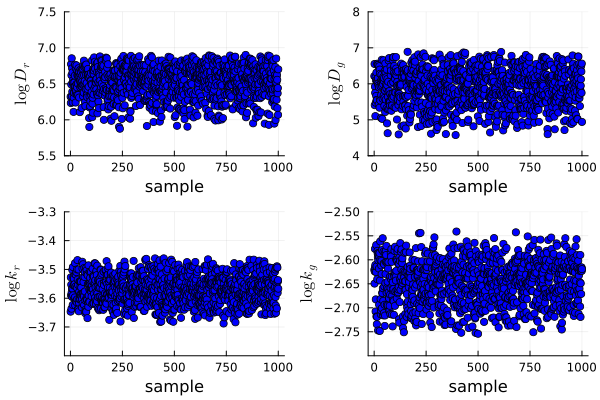

In [33]:
df=4
llstar=-quantile(Chisq(df),0.95)/2

M=1000 #Obtain M samples of parameters within the 95% confidence region
Drsample=zeros(M); Dgsample=zeros(M); krsample=zeros(M); kgsample=zeros(M); lls=zeros(M)
global kount = 0
while kount < M
logDrg=rand(Uniform(5.5,7.5))
logDgg=rand(Uniform(4.0,8.0))
logkrg=rand(Uniform(-3.8,-3.3))
logkgg=rand(Uniform(-2.8,-2.5))
    
    if (loglhood(count,ic,[logDrg,logDgg,logkrg,logkgg])-fmle) >= llstar 
    global kount+=1
    lls[kount]=loglhood(count,ic,[logDrg,logDgg,logkrg,logkgg])-fmle
    Drsample[kount]=logDrg;
    Dgsample[kount]=logDgg;
    krsample[kount]=logkrg;
    kgsample[kount]=logkgg;
    end
end

a1=scatter(Drsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log D_r",ylims=(5.5,7.5))
a2=scatter(Dgsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log D_g",ylims=(4,8))
a3=scatter(krsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log k_r",ylims=(-3.8,-3.3))
a4=scatter(kgsample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log k_g",ylims=(-2.8,-2.5))
a5=plot(a1,a2,a3,a4,layout=(2,2))
display(a5)

In [34]:
xx = 0:1:L
l_red_2=100*ones(length(xx)); l_red_3=100*ones(length(xx)); l_red_4=100*ones(length(xx))
l_green_2=100*ones(length(xx)); l_green_3=100*ones(length(xx)); l_green_4=100*ones(length(xx))

u_red_2=zeros(length(xx)); u_red_3=zeros(length(xx)); u_red_4=zeros(length(xx))
u_green_2=zeros(length(xx)); u_green_3=zeros(length(xx)); u_green_4=zeros(length(xx))


for i in 1:M # For each M parameter combinations from within the 95% confidence interval, solve the model
numsol=pdesolver(L,dx,N,T,ic,Drsample[i],Dgsample[i],krsample[i],kgsample[i])
    
r2 = linear_interpolation(0:dx:L,numsol[1,:,2],extrapolation_bc=Line()); 
r3 = linear_interpolation(0:dx:L,numsol[1,:,3],extrapolation_bc=Line()); 
r4 = linear_interpolation(0:dx:L,numsol[1,:,4],extrapolation_bc=Line());
g2 = linear_interpolation(0:dx:L,numsol[2,:,2],extrapolation_bc=Line()); 
g3 = linear_interpolation(0:dx:L,numsol[2,:,3],extrapolation_bc=Line()); 
g4 = linear_interpolation(0:dx:L,numsol[2,:,4],extrapolation_bc=Line());

    for j in 1:length(xx) #For each model solution compute the lower/upper prediction interval by computing the 0.05/0.95 quantiles of the noise model

        if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount < l_red_2[j] 
            l_red_2[j] = (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[1])/maxcount
        end
       
        if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount < l_red_3[j] 
            l_red_3[j]  = (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[1])/maxcount
        end

        if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount < l_red_4[j] 
            l_red_4[j] = (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[1])/maxcount
        end

        if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount < l_green_2[j] 
            l_green_2[j] = (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[1])/maxcount
        end
       
        if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount < l_green_3[j] 
            l_green_3[j]  = (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[1])/maxcount
        end

        if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount < l_green_4[j] 
            l_green_4[j] = (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[1])/maxcount
        end
        
        if (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount > u_red_2[j] 
            u_red_2[j]  = (quantile(Binomial(maxcount,r2(xx[j])),[.05,.95])[2])/maxcount
        end
       
        if (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount > u_red_3[j] 
            u_red_3[j] = (quantile(Binomial(maxcount,r3(xx[j])),[.05,.95])[2])/maxcount
        end

        if (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount > u_red_4[j] 
            u_red_4[j] = (quantile(Binomial(maxcount,r4(xx[j])),[.05,.95])[2])/maxcount
        end

        if (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount > u_green_2[j] 
            u_green_2[j]  = (quantile(Binomial(maxcount,g2(xx[j])),[.05,.95])[2])/maxcount
        end
       
        if (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount > u_green_3[j] 
            u_green_3[j] = (quantile(Binomial(maxcount,g3(xx[j])),[.05,.95])[2])/maxcount
        end

        if (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount > u_green_4[j] 
            u_green_4[j] = (quantile(Binomial(maxcount,g4(xx[j])),[.05,.95])[2])/maxcount
        end



    end



end

numsolmle=pdesolver(L,dx,N,T,ic,Drmle,Dgmle,krmle,kgmle);

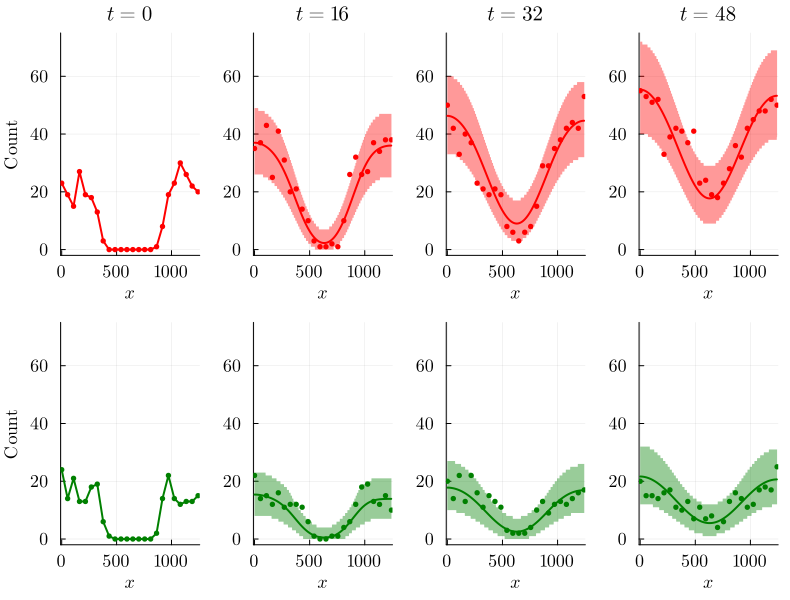

In [35]:
#Plot the prediction interval, the MLE solution and the data
ic1=scatter(xlocdata,count[1,:,1],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,xlims=(-10,L+15),ylims=(-2,75),title=L"t=0")
ic1=plot!(0:dx:L,maxcount*numsolmle[1,:,1],lw=2,color=:red)
ic1=plot!(xlabel=L"x",ylabel=L"\textrm{Count}",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
ic1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

ic2=scatter(xlocdata,count[2,:,1],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,xlims=(-10,L+15),ylims=(-2,75))
ic2=plot!(0:dx:L,maxcount*numsolmle[2,:,1],lw=2,color=:green)
ic2=plot!(xlabel=L"x",ylabel=L"\textrm{Count}",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
ic2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq1=plot(xx,maxcount*l_red_2,lw=0,fillrange=u_red_2*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq1=scatter!(xlocdata,count[1,:,2],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=16")
qq1=plot!(0:dx:L,maxcount*numsolmle[1,:,2],lw=2,color=:red)
qq1=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq2=plot(xx,maxcount*l_green_2,lw=0,fillrange=u_green_2*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq2=scatter!(xlocdata,count[2,:,2],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
qq2=plot!(0:dx:L,maxcount*numsolmle[2,:,2],lw=2,color=:green)
qq2=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq3=plot(xx,maxcount*l_red_3,lw=0,fillrange=u_red_3*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq3=scatter!(xlocdata,count[1,:,3],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=32")
qq3=plot!(0:dx:L,maxcount*numsolmle[1,:,3],lw=2,color=:red)
qq3=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq3=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq4=plot(xx,maxcount*l_green_3,lw=0,fillrange=u_green_3*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq4=scatter!(xlocdata,count[2,:,3],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
qq4=plot!(0:dx:L,maxcount*numsolmle[2,:,3],lw=2,color=:green)
qq4=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq4=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

qq5=plot(xx,maxcount*l_red_4,lw=0,fillrange=u_red_4*maxcount,fillalpha=0.40,color=:red,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq5=scatter!(xlocdata,count[1,:,4],markercolor=:red,markerstrokecolor=:red,markersize=3,legend=false,ylims=(-2,75),title=L"t=48")
qq5=plot!(0:dx:L,maxcount*numsolmle[1,:,4],lw=2,color=:red)
qq5=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq5=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)


qq6=plot(xx,maxcount*l_green_4,lw=0,fillrange=u_green_4*maxcount,fillalpha=0.40,color=:green,label=false,xlims=(-10,L+10),ylims=(-2,70))
qq6=scatter!(xlocdata,count[2,:,4],markercolor=:green,markerstrokecolor=:green,markersize=3,legend=false,ylims=(-2,75))
qq6=plot!(0:dx:L,maxcount*numsolmle[2,:,4],lw=2,color=:green)
qq6=plot!(xlabel=L"x",xticks = ([0,500,1000],[L"0", L"500", L"1000"]), yticks = ([0,20,40,60],[L"0", L"20", L"40", L"60"]),label=false)
qq6=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

rr1= plot(ic1,qq1,ic2,qq2,layout=(2,2))
rr2= plot(qq3,qq5,qq4,qq6,layout=(2,2))
rr3=plot(rr1,rr2,layout=(1,2),size=(790,600))
savefig(rr3,"Figure6.pdf")
display(rr3)